## Feature Engineering for rushing data 

In [1]:
#importing various libraries 
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials
# Print nicely
import pprint
#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

In [2]:
#data manipulation 
import pandas as pd 
import numpy as np

def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

#creating a moving avg function 
def move_avg(df, smooth_col, group_vals, window):
    out = df.groupby(group_vals, as_index = False)[smooth_col].rolling(window = window).mean()
    out = out.reset_index(level = 0, drop = True)
    return(out)

In [3]:
rush = read_file(sheet_name= 'rushing_processed_step1')

In [4]:
rrf = ['Yds', 'TD', 'FUM']
rush[rrf] = rush[rrf].astype(float)
rush['rush_fantasy_pts'] = rush['rush_fantasy_pts'].astype(float)

## Rush Feature Eng 

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
series = rush.rush_fantasy_pts

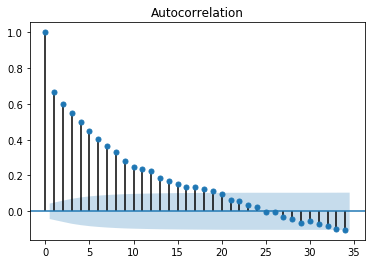

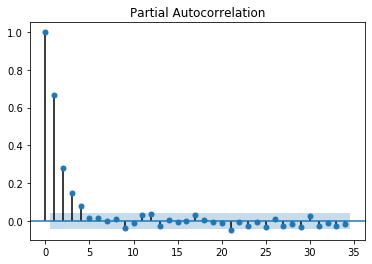

In [7]:
plot_acf(series)
plt.show()

plot_pacf(series)
plt.show()

In [8]:
rush_recap = read_file('2018_rushing_recap')
rush_recap[['Yds/G', 'TD', '2018_ppg']] = rush_recap[['Yds/G', 'TD', '2018_ppg']].astype(float)
rush_recap = rush_recap.rename(columns = {"Player":"Name", 'TD':'total_td', 'Int':'total_int', 'FUM':'total_fum'})
rush_recap = rush_recap.drop('Team', axis = 1)

In [9]:
cols = ['Yds', 'TD', 'rush_fantasy_pts']
lag3 = ['lag3_' + ''.join(x) for x in cols]
lag2 = ['lag2_' + ''.join(x) for x in cols]
# getting prior week data 
prior_week = ['last_week_' + ''.join(x) for x in ['Yds', 'TD', 'rush_fantasy_pts']]

In [10]:
joined = pd.merge(rush, rush_recap, on = 'Name', how = 'inner')
joined = joined.drop_duplicates()

In [11]:
joined[lag3] = move_avg(df = joined, smooth_col=cols, group_vals = 'Name', window = 3)
joined[lag2] = move_avg(df = joined, smooth_col = cols, group_vals = 'Name', window = 2)
joined[prior_week] = joined.groupby('Name')[['Yds', 'TD', 'rush_fantasy_pts']].shift(periods = 1, axis = 0)
big_list = lag3 + lag2
joined[big_list] = joined.groupby('Name')[big_list].shift(periods = 1, axis = 0)

In [12]:
joined.lag2_Yds = joined['lag2_Yds'].fillna(joined['Yds/G'])
joined.lag2_TD = joined['lag2_TD'].fillna(joined['total_td']/16)
joined.lag2_rush_fantasy_pts = joined['lag2_rush_fantasy_pts'].fillna(joined['2018_ppg'])

In [13]:
joined.lag3_Yds = joined['lag3_Yds'].fillna(joined['Yds/G'])
joined.lag3_TD = joined['lag3_TD'].fillna(joined['total_td']/16)
joined.lag3_rush_fantasy_pts = joined['lag3_rush_fantasy_pts'].fillna(joined['2018_ppg'])

In [14]:
joined.last_week_Yds = joined['last_week_Yds'].fillna(joined['Yds/G'])
joined.last_week_TD = joined['last_week_TD'].fillna(joined['total_td']/16)
joined.last_week_rush_fantasy_pts = joined['last_week_rush_fantasy_pts'].fillna(joined['2018_ppg'])

In [15]:
joined['yds_ration'] = joined.lag2_Yds/joined.lag3_Yds
joined['fantasy_pts_ratio'] = joined.lag2_rush_fantasy_pts/joined.lag3_rush_fantasy_pts

In [16]:
drop_vars = ['Yds/G', 'total_td', '2018_ppg', 'Team', 'Avg', '100yd_flag']
final_data = joined.drop(drop_vars, axis = 1)
print(final_data.shape)

(1223, 21)


### Writing the file to gsheets

In [17]:
# %load ../01_data-acq/write_function.py
def writer(data, sheet_name, share_email):
    #preparing the data to be written 
    data = data.fillna('na')
    data = data.astype(str)
    
    #Grabbing Parameters for looping 
    n_rows = data.shape[0]
    n_cols = data.shape[1]
    
    #creating sheets
     #Now will can access our google sheets we call client.open on StartupName
    sheet = client.create(sheet_name) 
    sheet.share(share_email,  perm_type='user', role='writer') #sharing my email 
    
    #getting cell list to batch update
    import string
    end_col = string.ascii_uppercase[n_cols - 1]
    end_row = n_rows + 1
    
    sheet_range = 'A1:'+ end_col + str(end_row)
    
    #turning df to one long list 
    df_as_list = data.stack().tolist()
    df_as_list = data.columns.tolist() + df_as_list
    
    #getting the target sheet 
    ws = sheet.get_worksheet(0)
    cell_list = ws.range(sheet_range)
    
    #writing df list to cell range list 
    for i in range(0, len(cell_list)):
        cell_list[i].value = df_as_list[i]
        
    #batch updating 
    ws.update_cells(cell_list)

In [18]:
writer(data = final_data, sheet_name = 'rushing_data_model_ready', share_email = my_email)